# Zdanie 1
Przeprowadzić analizę mocy wybranych testów statystycznych w różnych warunkach. Badaniu poddane zostaną testy Kołmogorowa, Lillieforsa, Andersona-Darlinga oraz test Kołmogorowa-Smirnowa, zarówno w klasycznej wersji, jak i z wykorzystaniem transformacji PIT (probability integral transform).

    n              test    pit  power
0  10                KS  False  0.004
1  10                KS   True  0.000
2  10        Lilliefors  False  0.302
3  10        Lilliefors   True  0.214
4  10  Anderson-Darling  False  0.423


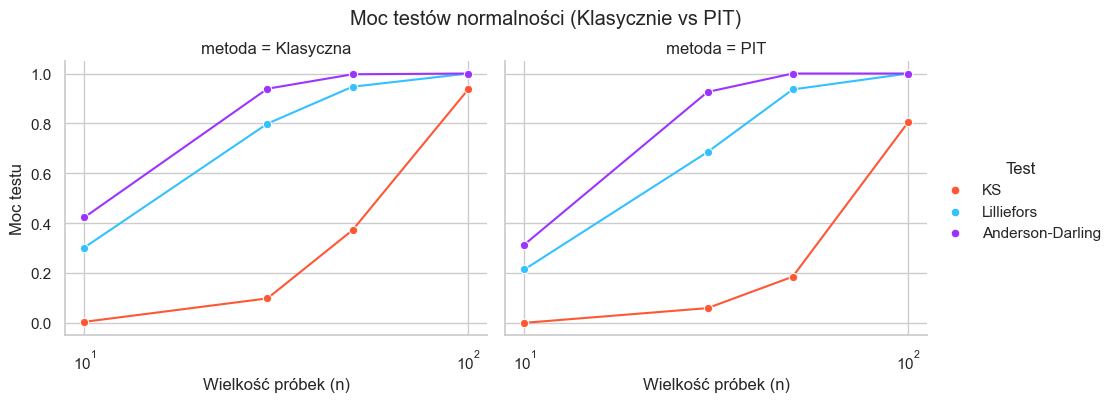

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.diagnostic import lilliefors, normal_ad

sns.set_theme(style="whitegrid")
custom_palette = ["#FF5733", "#33C1FF", "#9D33FF", "#33FF57"]

# Parametry symulacji
alpha = 0.05
n_values = [10, 30, 50, 100]			# Wielkość próbek
k = 1000										# Liczba powtórzeń symulacji
test_names = ["KS", "Lilliefors", "Anderson-Darling"]
pit_options = [False, True]         # Wariancje: klasyczny i PIT

def pit_transform(data):
    return stats.norm.cdf(data, loc=np.mean(data), scale=np.std(data, ddof=1))


# Każda funkcja przyjmuje wektor danych x i zwraca p-wartość. Do testu KS używam testu z estymacją parametrów.
get_p_value = {
    "KS": lambda x: stats.kstest(x, "norm", args=(np.mean(x), np.std(x, ddof=1)))[1],
    "Lilliefors": lambda x: lilliefors(x, dist="norm")[1],
    "Anderson-Darling": lambda x: normal_ad(x)[1]
}


def simulate_power(n, test_name, use_pit, dist_func):
    p_values = []
    test_func = get_p_value[test_name]
    for i in range(k):
        # generuje próbkę
        data = dist_func(size=n)
        if use_pit:
            data = pit_transform(data)
        p_val = test_func(data)
        p_values.append(p_val)
    return np.mean(np.array(p_values) < alpha)

# Obliczam moc testów
rows = []

# Dla  wielkość próbek, testu, wariantowi (klasyczny, PIT)
for n in n_values:
    for test in test_names:
        for use_pit in pit_options:
            power = simulate_power(n, test, use_pit, dist_func=np.random.exponential)
            rows.append({
                "n": n,
                "test": test,
                "pit": use_pit,
                "power": power
            })

df_results = pd.DataFrame(rows)
print(df_results.head())

df_results["metoda"] = df_results["pit"].map({False: "Klasyczna", True: "PIT"})

g = sns.FacetGrid(df_results, col="metoda", hue="test", height=4, palette=custom_palette, aspect=1.2)
g.map(sns.lineplot, "n", "power", marker="o")
g.map(sns.scatterplot, "n", "power")

for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_xlabel("Wielkość próbek (n)")
    ax.set_ylabel("Moc testu")
    
g.add_legend(title="Test")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Moc testów normalności (Klasycznie vs PIT)")
plt.show()

Jak widzimy po wizualizacji, **najlepiej** od samego początku radzi sobie test **Andersona-Darlinga**, osiąga najwyższą moc od samego począku.
**Nieco słabiej** ale nadal bardzo dobrze radzi sobie test **Lillieforsa**. Wraz ze wzrostem wielkości próby, skuteczność obu testów zaczyna się zblżać do siebie.
**Mocno słabiej** radzi sobie test **Kołmogorowa-Smirnowa**. Jego moc jest sporo mniejsza w porówanniu do poprzednich dwóch testów. Zaczynając od małych prób, gdzie dużo rzadziej odrzuca błędną hipotezę o normalności.
**Po transformacji PIT** można zauważyć, że **moc zaczyna spadać**. Tak więc niestety zastosowanie transformacji PIT w tych przypadkach **działa na niekorzyść**

# Zadanie 2
Wpływ rozkładu danych na moc testów
Zbadanie mocy testów w przypadku, gdy dane pochodzą z różnych rozkładów:

- Rozkład t-Studenta (z uwzględnieniem liczby stopni swobody),
- Rozkład χ2 (z uwzględnieniem liczby stopni swobody),
- Rozkłady normalne o różnych odchyleniach standardowych przy stałej wartości oczekiwanej,
- Rozkłady NIG i gamma o różnych parametrach.

### Wpływ liczebności danych na moc testów
Analiza mocy testów w zależności od wielkości próbki. Przeanalizować różne liczebności próbki, aby określić, jak zmienia się moc testu w miarę wzrostu liczby obserwacji.

                 Test   N Rozklad    Moc
0          Lilliefors  10    t(1)  0.570
1    Anderson-Darling  10    t(1)  0.612
2  Kolmogorov-Smirnov  10    t(1)  0.194
3          Lilliefors  30    t(1)  0.953
4    Anderson-Darling  30    t(1)  0.974


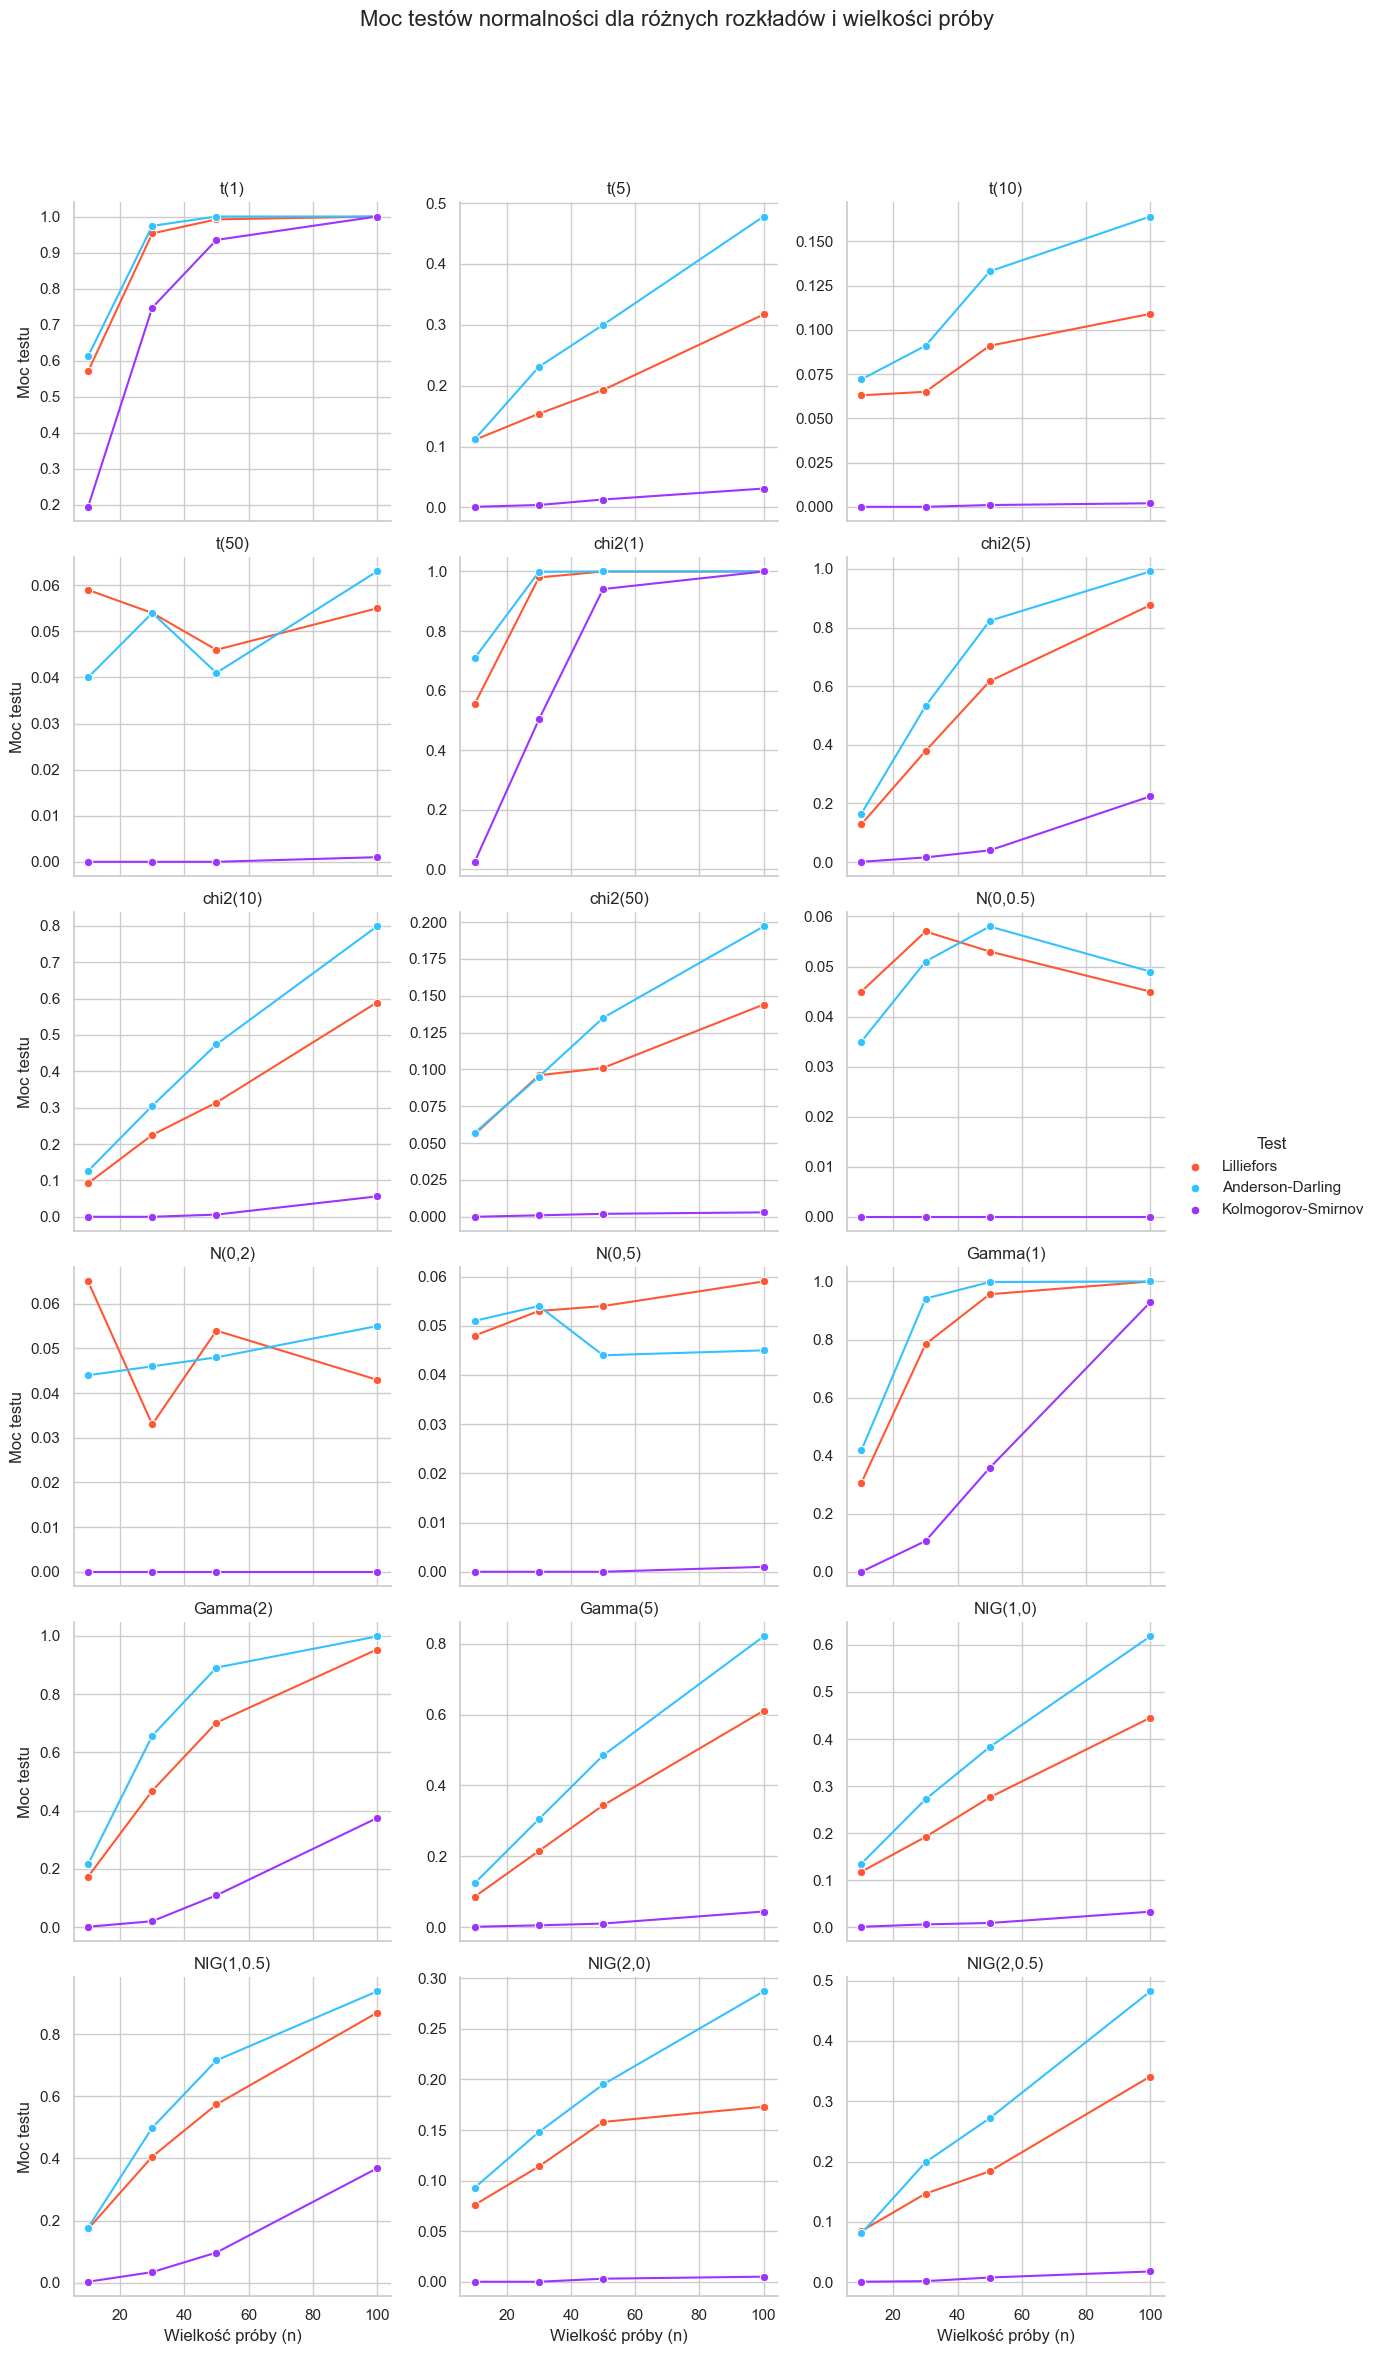

In [13]:
# Parametry
stopnie_swobody = [1, 5, 10, 50]        # dla t-Studenta oraz chi-kwadrat
sd_norm = [0.5, 2, 5]                   # dla rozkładu normalnego, przy średniej = 0
shape_gamma = [1, 2, 5]                 # dla rozkładu gamma
alpha_nig = [1, 2]                      # dla NIG (Normal Inverse Gaussian)
beta_nig = [0, 0.5]

tests = {
    "Lilliefors": lambda x: lilliefors(x, dist="norm")[1],
    "Anderson-Darling": lambda x: normal_ad(x)[1],
    "Kolmogorov-Smirnov": lambda x: stats.kstest(x, "norm", args=(np.mean(x), np.std(x, ddof=1)))[1]
}

# Pomocnicza funkcja do obliczania mocy testu
def power_test(dist_fun, n, test_fun, alpha=0.05, k=1000):
    rejections = []
    for _ in range(k):
        x = dist_fun(n)
        p_val = test_fun(x)
        rejections.append(p_val < alpha)
    return np.mean(rejections)

results = []
# t-Studenta
for df in stopnie_swobody:
    for n in n_values:
        # generuje próbkę z rozkładu t z podanym df
        dist_fun = lambda n, df=df: stats.t.rvs(df, size=n)
        for test_name, test_fun in tests.items():
            pwr = power_test(dist_fun, n, test_fun, alpha, k)
            results.append({
                "Test": test_name,
                "N": n,
                "Rozklad": f"t({df})",
                "Moc": pwr
            })

# Rozkład chi-kwadrat
for df in stopnie_swobody:
    for n in n_values:
        dist_fun = lambda n, df=df: np.random.chisquare(df, size=n)
        for test_name, test_fun in tests.items():
            pwr = power_test(dist_fun, n, test_fun, alpha, k)
            results.append({
                "Test": test_name,
                "N": n,
                "Rozklad": f"chi2({df})",
                "Moc": pwr
            })

# Rozkład normalny o różnych odchyleniach standardowych
for sd in sd_norm:
    for n in n_values:
        dist_fun = lambda n, sd=sd: np.random.normal(loc=0, scale=sd, size=n)
        for test_name, test_fun in tests.items():
            pwr = power_test(dist_fun, n, test_fun, alpha, k)
            results.append({
                "Test": test_name,
                "N": n,
                "Rozklad": f"N(0,{sd})",
                "Moc": pwr
            })

# Rozkład gamma
for shape in shape_gamma:
    for n in n_values:
        dist_fun = lambda n, shape=shape: np.random.gamma(shape, scale=1, size=n)
        for test_name, test_fun in tests.items():
            pwr = power_test(dist_fun, n, test_fun, alpha, k)
            results.append({
                "Test": test_name,
                "N": n,
                "Rozklad": f"Gamma({shape})",
                "Moc": pwr
            })

# Rozkład NIG
for a_val in alpha_nig:
    for b_val in beta_nig:
        for n in n_values:
            dist_fun = lambda n, a=a_val, b=b_val: stats.norminvgauss.rvs(a, b, loc=0, scale=1, size=n)
            for test_name, test_fun in tests.items():
                pwr = power_test(dist_fun, n, test_fun, alpha, k)
                results.append({
                    "Test": test_name,
                    "N": n,
                    "Rozklad": f"NIG({a_val},{b_val})",
                    "Moc": pwr
                })

df_results = pd.DataFrame(results)
print(df_results.head())

g = sns.FacetGrid(df_results, col="Rozklad", col_wrap=3, hue="Test", height=4, palette=custom_palette, sharey=False)
g.map(sns.lineplot, "N", "Moc", marker="o")
g.map(sns.scatterplot, "N", "Moc")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Wielkość próby (n)", "Moc testu")
g.add_legend(title="Test")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Moc testów normalności dla różnych rozkładów i wielkości próby", fontsize=16)
plt.show()

Dla rozkłady **t-studenta** (1) testy **osiągają wysoką moc**. Wraz ze wzrostem stopnii swobody rozkład zbliża się do rozkładu normalnego, tak jak moglibyśmy podejrzewać znając teorię. Natomiast test **Kołmogorowa-Smirnowa** ma **sporo słabszą moc w porówaniu do innych testów** wraz ze wzrostem stopnii swobody.

Dla rozkładów chi-kwadrat szcególnie tych z mniejszą wartością stopniii swobody **moc testów szybko wzrasta z wielkością próby**. Test Kołmogorowa-Smirnowa zachowuję się podobnie jak przy rozkładzie t-studenta, czyli wyraźnie spada jest skuteczność.

Dla rozkładów gamma i NIG widzimy podobną zależność odnośnie testów jak dla rozkładu chi-kwadrat

**W każdym przypadku** test **Kołmoogorowa-Smirnowa** radzi sobie **najgorze**, czasem wyraźnie gorzej.
Wraz ze **wzrostem wielkości** próby wszytskie **testy radzą sobie lepiej**, czyli ich moc wzrasta. Zwiększenie liczebności próby działa pozytywnie na wyniki

# Zadanie 3
Analiza błędu I rodzaju
Przeprowadzenie symulacji w celu oszacowania odsetka odrzuceń prawdziwej hipotezy zerowej (błąd I rodzaju) w przypadku weryfikacji zgodności z rozkładem NIG oraz gamma. Porównanie wyników klasycznej metody testowania z metodą wykorzystującą PIT.

In [18]:
def run_tests(sample):
    p_lillie = lilliefors(sample, dist="norm")[1]
    p_ad = normal_ad(sample)[1]
    mu, sigma = np.mean(sample), np.std(sample, ddof=1)
    p_ks = stats.kstest(sample, 'norm', args=(mu, sigma))[1]
    
    return {
        "lillie": p_lillie < alpha,
        "ad": p_ad < alpha,
        "ks": p_ks < alpha
    }

# Funkcja pomocnicza do symulacji odrzuceń
def simulate_rejections(distribution="nig"):
    results_list = []
    for n in n_values:
        # Tablice na wyniki dla k symulacji dla każdego testu
        rejections_lillie = []
        rejections_ad = []
        rejections_ks = []
        
        for i in range(k):
            if distribution == "nig":
                sample = stats.norminvgauss.rvs(a=3, b=0, loc=0, scale=1, size=n)
            elif distribution == "gamma":
                sample = np.random.gamma(shape=2, scale=2, size=n)
            elif distribution == "t":
                sample = stats.t.rvs(df=5, size=n)
            else:
                raise ValueError("Nieznany rozkład")
                
            test_results = run_tests(sample)
            rejections_lillie.append(test_results["lillie"])
            rejections_ad.append(test_results["ad"])
            rejections_ks.append(test_results["ks"])
        
        # Obliczam średni odsetek odrzuceń dla każdej metody.
        avg_lillie = np.mean(rejections_lillie)
        avg_ad = np.mean(rejections_ad)
        avg_ks = np.mean(rejections_ks)
        
        results_list.append({
            "n": n,
            "lillie": avg_lillie,
            "ad": avg_ad,
            "ks": avg_ks,
            "distribution": distribution
        })
    return pd.DataFrame(results_list)

results_nig = simulate_rejections("nig")
results_gamma = simulate_rejections("gamma")
results_t = simulate_rejections("t")

results_all = pd.concat([results_nig, results_gamma, results_t], ignore_index=True)

/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.draw()


Text(0.5, 0.98, 'Błąd I rodzaju testów normalności')

/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


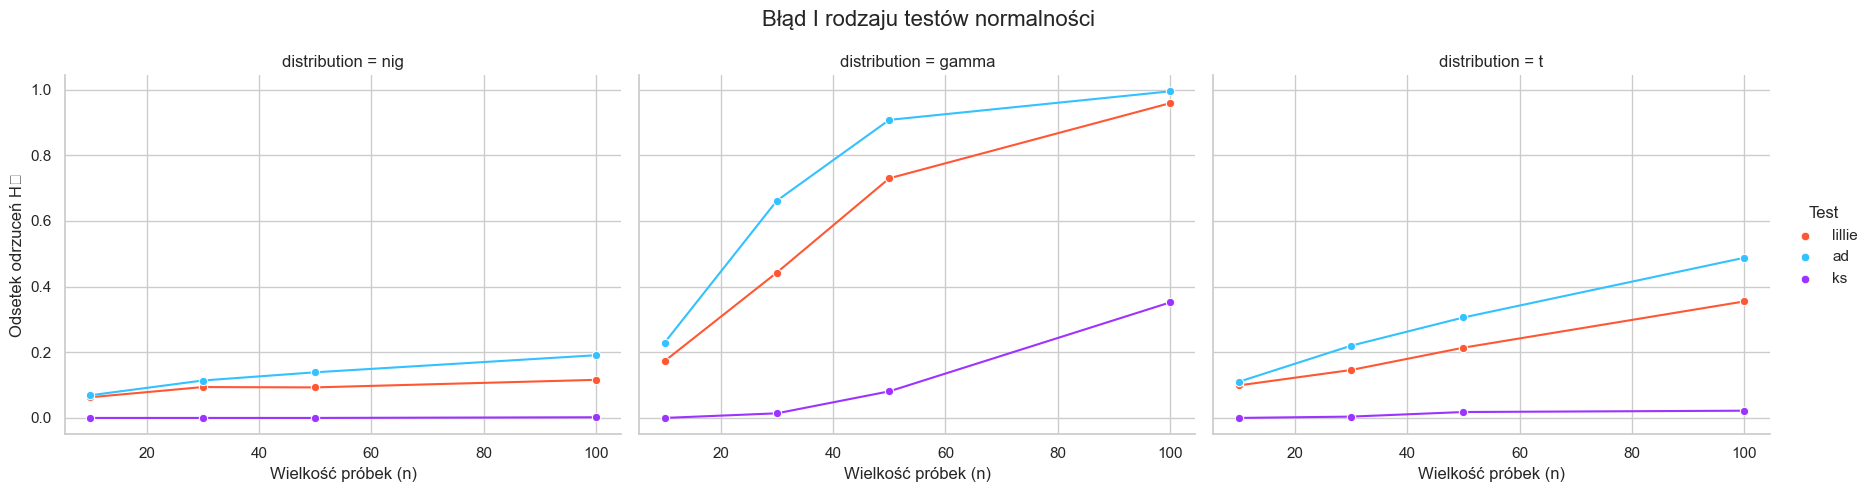

In [19]:
plot_data = results_all.melt(id_vars=["n", "distribution"], 
                             value_vars=["lillie", "ad", "ks"],
                             var_name="test", value_name="rejection_rate")

plt.figure(figsize=(10, 6))
g = sns.FacetGrid(plot_data, col="distribution", height=5, palette=custom_palette, hue="test", sharey=True, aspect=1.2)
g.map_dataframe(sns.lineplot, x="n", y="rejection_rate", marker="o")
g.map_dataframe(sns.scatterplot, x="n", y="rejection_rate", legend=False)
g.set(yscale="linear")
g.set_axis_labels("Wielkość próbek (n)", "Odsetek odrzuceń H₀")
g.add_legend(title="Test")
plt.subplots_adjust(top=0.85)
plt.suptitle("Błąd I rodzaju testów normalności", fontsize=16)

Dla rozkładu **NIG Kołmogorow-Smirnow** zupełnie sobie *nie radzi* i przez cały czas wskazuje, iż rozkłąd jest normalny. Jak możemy zauważyć test **Andersona-Darlinga i Lilliefors** tak jak moglibyśmy się spodziewać **wypadają najlepiej** i odpowiednio **pokazują nam nienormalność danych**. Tak jak z poprzednich wzniosków test Kołmogorow-Smirnow radzi sobie najgorzej

Dla rozkładu gamma, gdzie dane nie mają rozkładu normalnego, więc **także oczekuję wysokiego odsetka** odrzeceń hipotezy H0 i tak też jest. Testy zachowują się podobnie jak dla rozkłądu NIG, czyli Kołmogorow-Smirnow najsłabiej a pozostała dwójka wyraźnie korzystniej

Testy dla rozkładu T-studenta zachowują się tak samo jak dla pozostałej dwójki.